# **Data Cleaning Notebook**

## Objectives

* Evaluate missing data
* Clean Data

## Inputs

* inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv

## Outputs

* Generate cleaned Test and Train sets 
* Data cleaning pipeline

## Conclusions

* Drop ['EnclosedPorch', 'WoodDecksF']
* Cateogorical imputer- ['GarageFinish', 'BsmtFinType1']
* Median imputer- ['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea']


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-predictive-analytics/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-predictive-analytics'

# Load collected data

In [4]:
import pandas as pd
df = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


# Data Exploration

First we need to find the values with missing data, store in an array and create a Pandas profiling report.
This shows 9 variables with missing data, the total of each can be seen in the report.

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Data Cleaning

# Assessing Missing Data Levels

* Custom function to display missing data levels in a DataFrame. 

In [7]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

We check missing data levels for the collected dataset. This shows the number of missing rows and the percentage of missing values per feature as well as data type.

In [8]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


We observe that EnclosedPorch and WoodDeckSF exhibit high levels of missing data, suggesting that these features may have limited predictive value for estimating the sale price.

# Dealing With Missing Data

We analyse and visualize the effects of data cleaning methods on specified variables.

In [9]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method):
    """
    Analyse and visualize the distribution effect of data cleaning on variables.

    Parameters:
    - df_original: Original dataset (DataFrame)
    - df_cleaned: Cleaned dataset (DataFrame)
    - variables_applied_with_method: List of variables to analyse
    """      
    flag_count = 1  

    categorical_vars = [var for var in variables_applied_with_method if df_original[var].dtype == 'object']
    numerical_vars = [var for var in variables_applied_with_method if df_original[var].dtype != 'object']

    print("\n=====================================================================================")
    print("* Distribution Effect Analysis After Data Cleaning Method in the following variables:\n")
    print(f"{variables_applied_with_method}\n")

    for var in categorical_vars:
        df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var]})
        df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var]})
        df_combined = pd.concat([df1, df2], axis=0)

        plt.figure(figsize=(15, 5))
        sns.countplot(data=df_combined, x="Value", hue="Type", palette=['#432371', "#FAAE7B"])
        plt.title(f"Distribution Plot {flag_count}: {var} (Categorical Variable)")
        plt.xticks(rotation=90)
        plt.legend(title="Dataset")
        plt.xlabel(var)
        plt.ylabel("Count")
        plt.show()

        flag_count += 1

    for var in numerical_vars:
        plt.figure(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True, element="step")
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True, element="step")
        plt.title(f"Distribution Plot {flag_count}: {var} (Numerical Variable)")
        plt.legend(title="Dataset")
        plt.xlabel(var)
        plt.ylabel("Frequency")
        plt.show()

        flag_count += 1

### Numerical missing values

We define the identified numerical variables with missing data for targeted imputation.

In [10]:
variables_method = ['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF', 'EnclosedPorch']
variables_method

['2ndFlrSF',
 'BedroomAbvGr',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF',
 'EnclosedPorch']

We apply the Median Imputation method to handle missing data across the selected numerical variables. This replaces missing values with the median of the respective variable, ensuring robustness against outliers. 

In [11]:
from feature_engine.imputation import MeanMedianImputer

imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
df_method = imputer.fit_transform(df)

We use the Data Cleaning Effect function to visualize the impact of this method on the distribution of numerical variables, comparing the original and cleaned datasets.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:

['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF', 'EnclosedPorch']



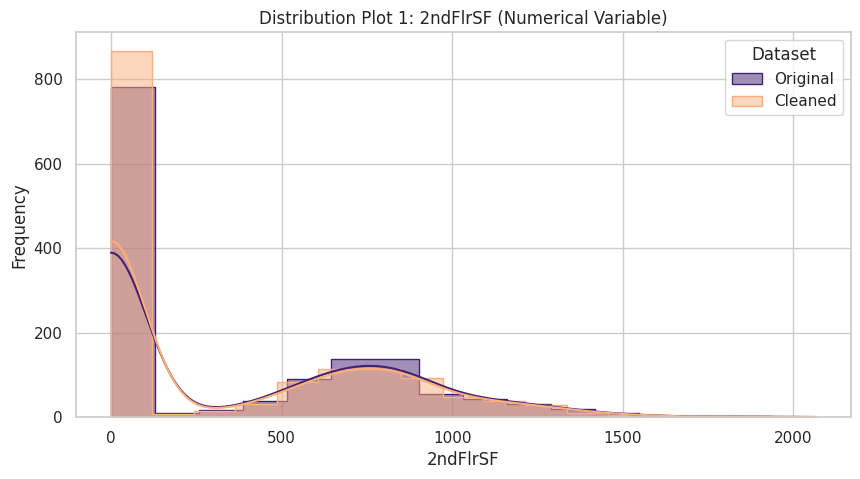

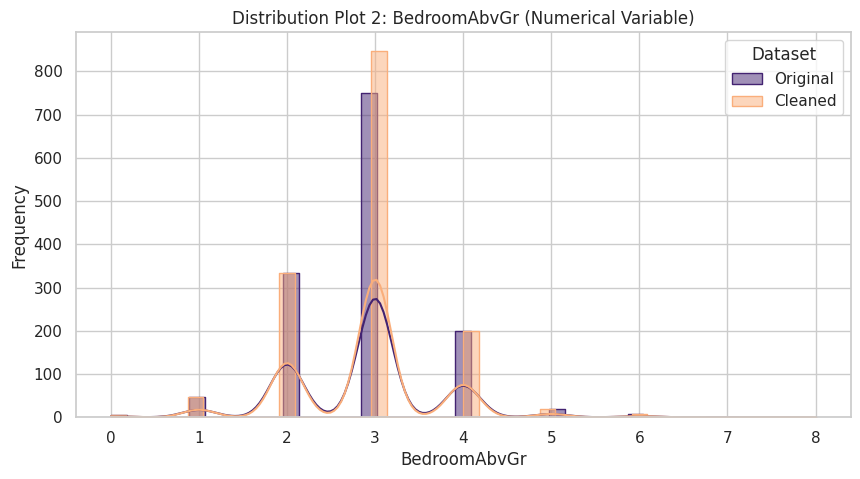

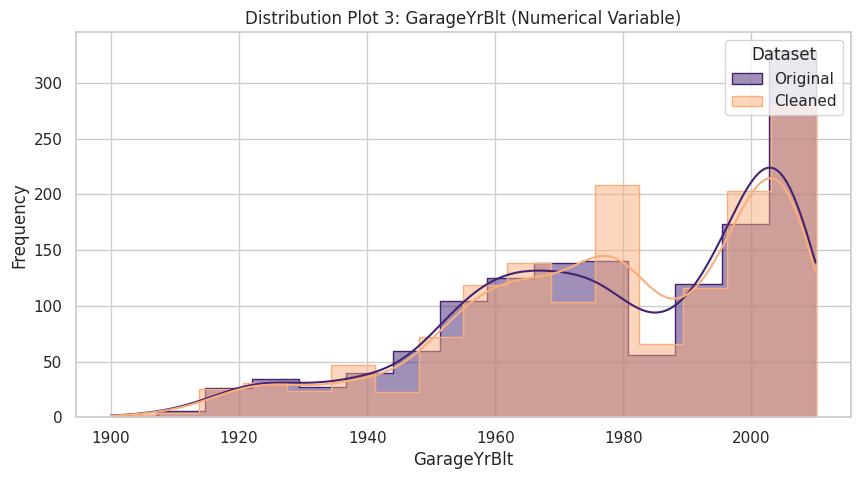

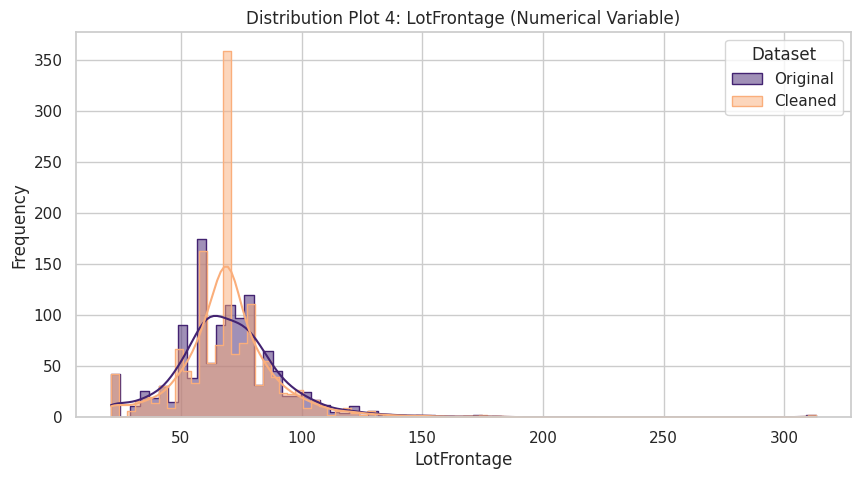

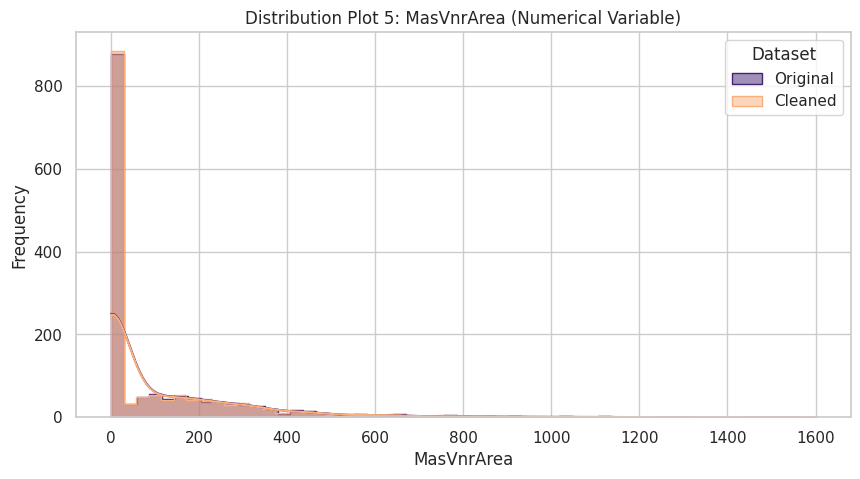

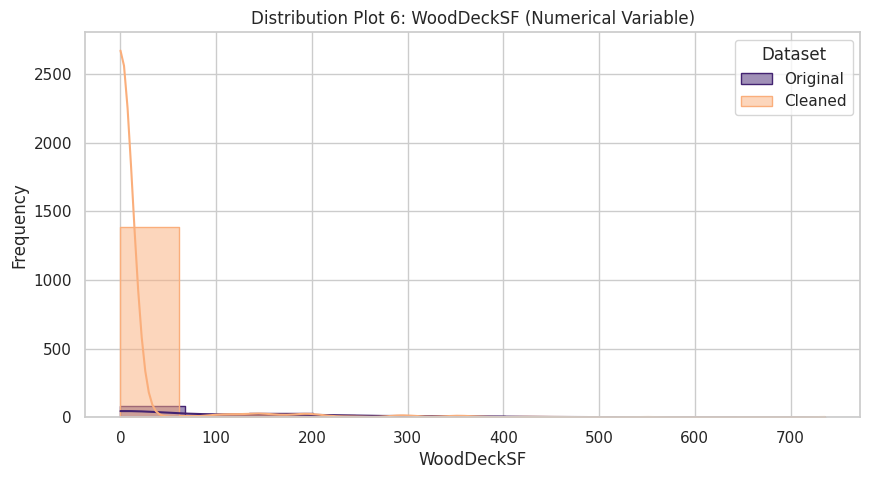

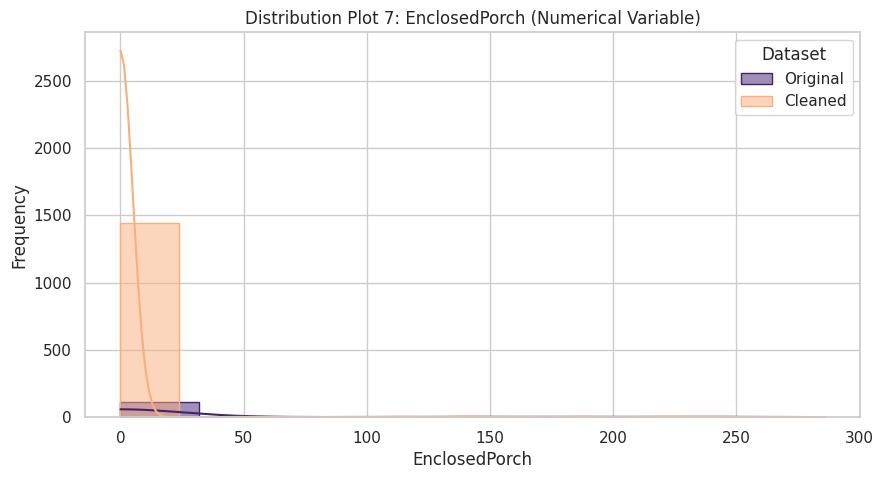

In [12]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

### Categorical missing values

We define the categorical variables with missing data for targeted imputation. 

In [13]:
variables_method = ['GarageFinish', 'BsmtFinType1']
variables_method

['GarageFinish', 'BsmtFinType1']

We introduce a new category called Missing to account for variables with missing data. This is distinct from None, as it is unclear whether the variable is missing due to omission or if it genuinely represents the absence of a value.

In [14]:
from feature_engine.imputation import CategoricalImputer

imputer = CategoricalImputer(imputation_method='missing',fill_value='Missing',
                             variables=variables_method)

df_method = imputer.fit_transform(df)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:

['GarageFinish', 'BsmtFinType1']



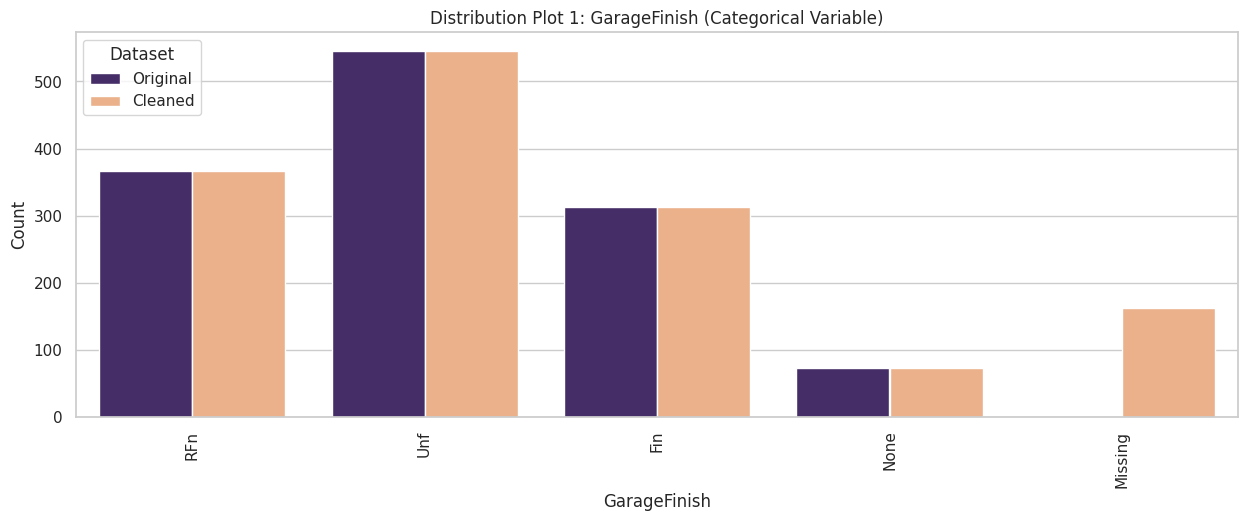

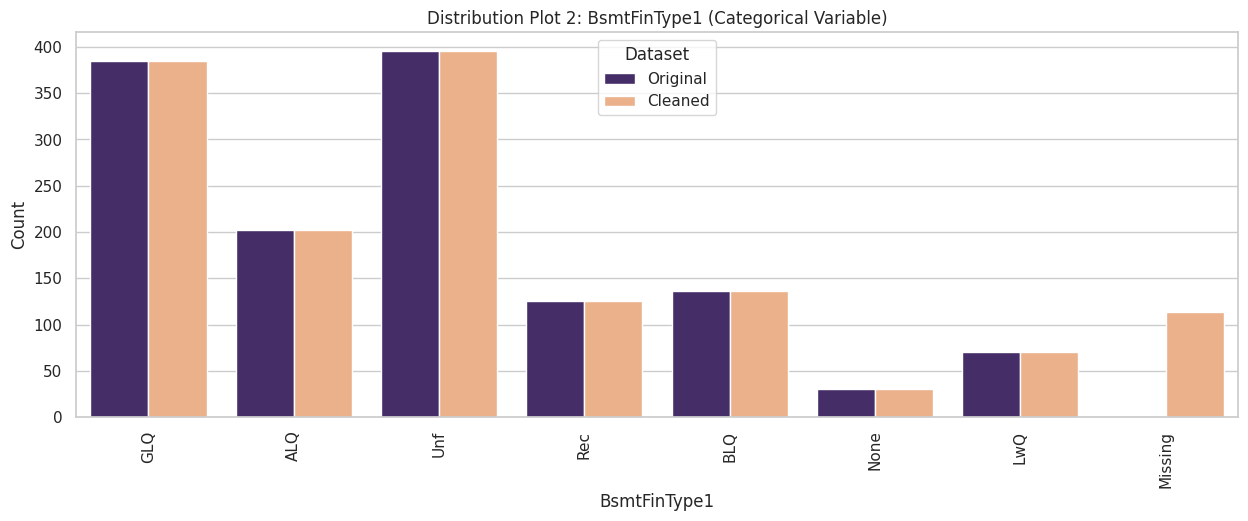

In [15]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

## Data Cleaning Summary

1. Drop Variables: Remove EnclosedPorch and WoodDeckSF from the dataset as they contain over 88% missing values, making them unsuitable for reliable analysis or imputation.

2. Median Imputation: Apply the median imputation method to the following numerical variables with missing data: LotFrontage, GarageYrBlt, MasVnrArea, BedroomAbvGr, and 2ndFlrSF. This approach replaces missing values with the median of each respective variable, ensuring robustness against outliers.

3. Categorical Imputation: Assign the category 'Missing' to fill missing values in the categorical variables GarageFinish and BsmtFinType1. This explicitly captures the absence of data without conflating it with meaningful categories.

# Split Train and Test Models

We split the dataset into Train and Test sets to evaluate the effectiveness of our imputation methods. The imputation techniques are applied to the Train set, allowing the model to learn from the cleaned data. We then assess the performance and impact of these methods on the Test set to ensure generalisability and robustness

In [16]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [17]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 9 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


### 1. Drop Variables

We are dropping EnclosedPorch and WoodDeckSF as these have over 88% missing values.

In [18]:
variables_method = ['EnclosedPorch', 'WoodDeckSF' ]

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")

* 2 variables to drop 

['EnclosedPorch', 'WoodDeckSF']


We create a separate DataFrame applying this imputation approach to the selected variables.

In [19]:
from feature_engine.selection import DropFeatures

imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

We verify that the selected variables have been successfully dropped by checking that they are no longer present in the transformed DataFrame.

In [20]:
remaining_variables = set(variables_method).intersection(set(df_method.columns))

if not remaining_variables:
    print("Success: All specified variables have been dropped.")
else:
    print(f"Failure: These variables were not dropped: {remaining_variables}")

df_method.shape


Success: All specified variables have been dropped.


(1168, 22)

We can now apply these changes to both Train and Test sets.

In [21]:
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

We can evaluate the missing data

In [22]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


In [23]:
missing_features_count = TrainSet.isnull().any().sum()
print(f"There are {missing_features_count} features with missing data.")

There are 7 features with missing data.


### Median Imputing

We now impute the median values for numerical variables with missing data

In [24]:
variables_method = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BedroomAbvGr', '2ndFlrSF' ]
print(f"* {len(variables_method)}  median\n\n"
    f"{variables_method}")

* 5  median

['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BedroomAbvGr', '2ndFlrSF']



* Distribution Effect Analysis After Data Cleaning Method in the following variables:

['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BedroomAbvGr', '2ndFlrSF']



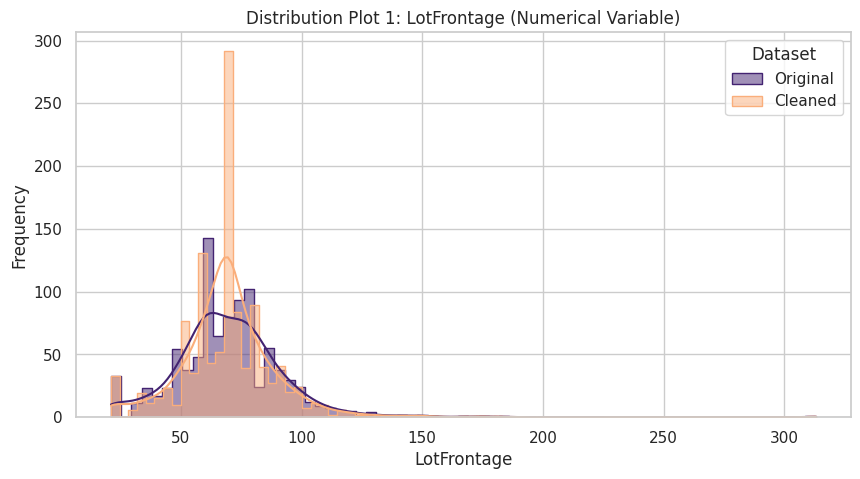

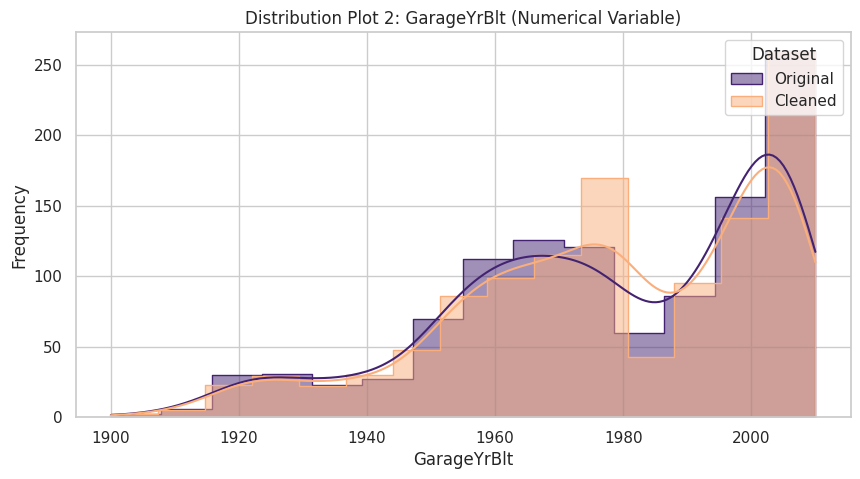

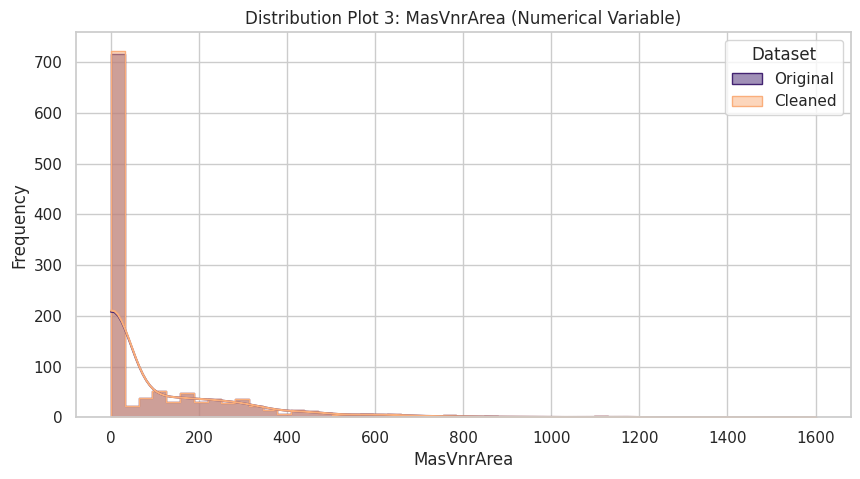

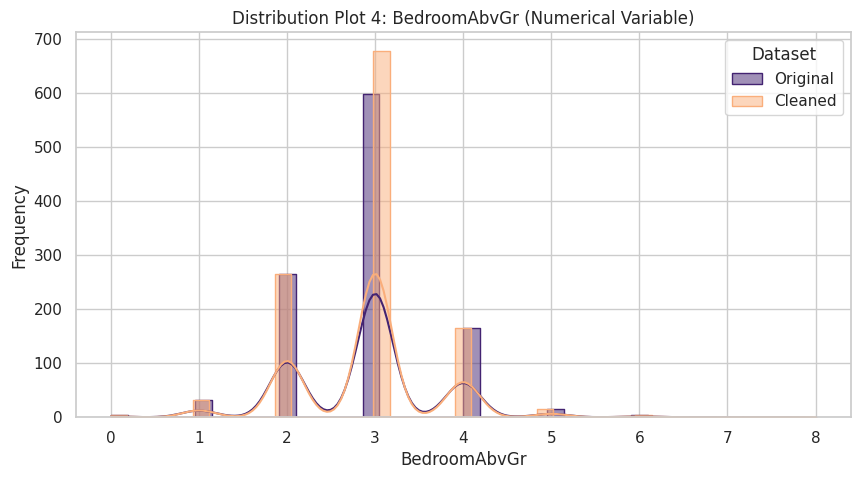

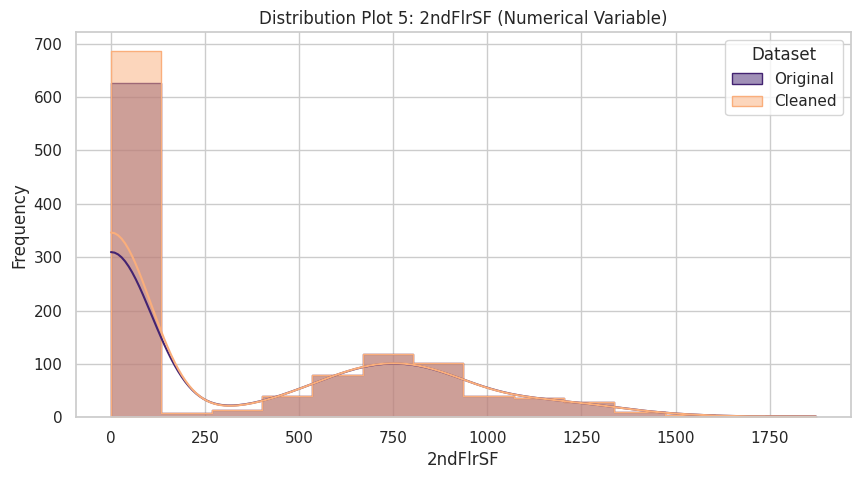

In [25]:
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

In [26]:
df_method.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
618,1828,0.0,3.0,Av,48,NaN,1774,774,Unf,2007.0,...,11694,90.0,452.0,108,5,9,1822,2007,2007,314813
870,894,0.0,2.0,No,0,Unf,894,308,NaN,1962.0,...,6600,60.0,0.0,0,5,5,894,1962,1962,109500
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,...,13360,80.0,0.0,0,7,5,876,1921,2006,163500
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,...,13265,69.0,148.0,59,5,8,1568,2002,2002,271000
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,...,13704,118.0,150.0,81,5,7,1541,2001,2002,205000


### Imputation Analysis
General Observation:

The missing values have been replaced with the median value for each feature. While this method is robust against outliers, it has introduced subtle changes in the distribution of some features, which could influence their predictive power.

Feature: LotFrontage:<br>
The imputed median value (~70) now accounts for a disproportionately large number of observations compared to the original distribution.
This concentration of values around the median could reduce the feature's variability and potentially affect its predictive accuracy in capturing the true relationship with the target variable (SalePrice).

Feature: GarageYrBlt:<br>
While imputing the missing values in GarageYrBlt around the median year helps address the missing data, it may significantly impact the predictive power of this feature. Given that the age of the garage and property can strongly influence sale price, this approach might oversimplify the variability and dilute the feature's ability to capture its true relationship with the target variable.

Fit transform the changes to the Train and Test sets

In [27]:
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

We evaluate the current missing data levels

In [28]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object


### Categorical Imputing

We create another category 'missing' to define the missing data.

In [29]:
variables_method = [ 'GarageFinish', 'BsmtFinType1' ]
print(f"* {len(variables_method)}  categorical\n\n"
    f"{variables_method}")

* 2  categorical

['GarageFinish', 'BsmtFinType1']



* Distribution Effect Analysis After Data Cleaning Method in the following variables:

['GarageFinish', 'BsmtFinType1']



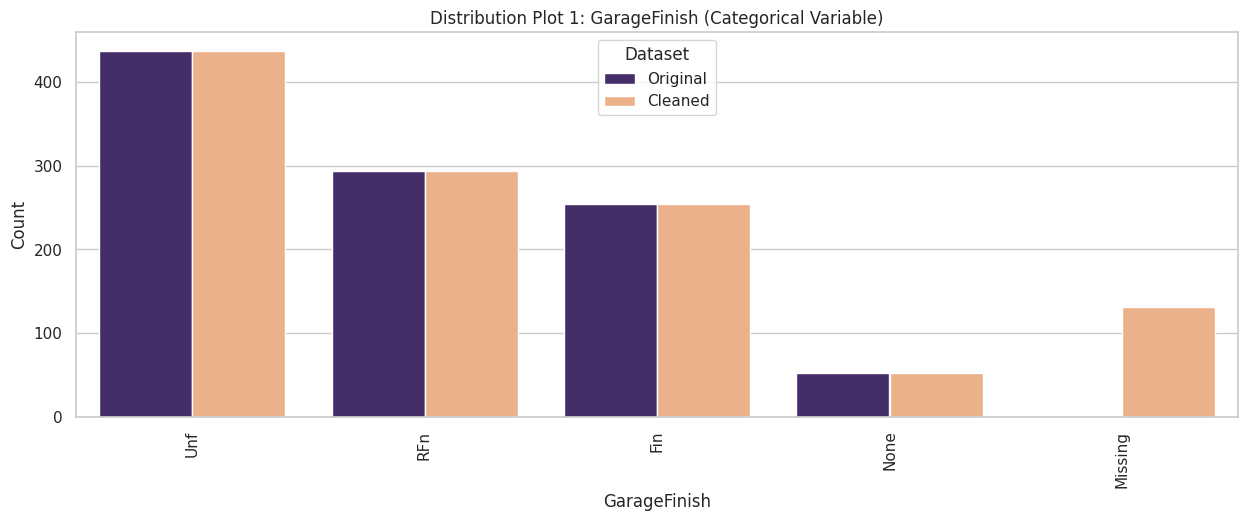

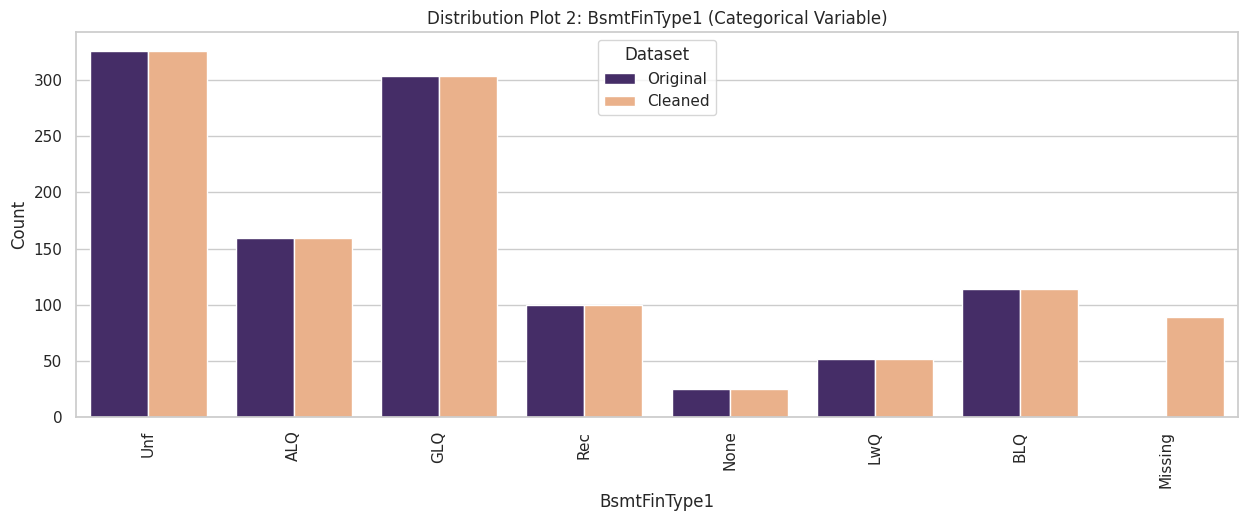

In [30]:
from feature_engine.imputation import CategoricalImputer

imputer = CategoricalImputer(imputation_method='missing',fill_value='Missing', variables=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

In [31]:
df_method.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
618,1828,0.0,3.0,Av,48,Missing,1774,774,Unf,2007.0,...,11694,90.0,452.0,108,5,9,1822,2007,2007,314813
870,894,0.0,2.0,No,0,Unf,894,308,Missing,1962.0,...,6600,60.0,0.0,0,5,5,894,1962,1962,109500
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,...,13360,80.0,0.0,0,7,5,876,1921,2006,163500
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,...,13265,69.0,148.0,59,5,8,1568,2002,2002,271000
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,...,13704,118.0,150.0,81,5,7,1541,2001,2002,205000


Another category of missing has been added to handle the missing data. This does not effect the categories already present in the feature. 
The feature engineering process will handle the values as numeric.

Evaluate changes to the Trainset

In [32]:
imputer = CategoricalImputer(imputation_method='missing',fill_value='Missing', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

We finally check once more for missing values.

In [33]:
EvaluateMissingData(TrainSet)
EvaluateMissingData(TestSet)

,RowsWithMissingData,PercentageOfDataset,DataType


---

We save cleaned train and test sets

# Push files to Repo

In [34]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)


[Errno 17] File exists: 'outputs/datasets/cleaned'


## Train Set

In [35]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test set

In [36]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)